# Unsupervised Discovery of Interpretable Directions in the GAN Latent Space

This notebook is for implementing `Unsupervised Discovery of Interpretable Directions in the GAN Latent Space` from the paper [Unsupervised Discovery of Interpretable Directions in the GAN Latent Space](https://arxiv.org/abs/2002.03754) with [Tensorflow](https://www.tensorflow.org). <br>
[MNIST data](http://yann.lecun.com/exdb/mnist/) will be used.

Reference: [hwalsuklee's Github](https://github.com/hwalsuklee/tensorflow-generative-model-collections)

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

## Import Libraries

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import datetime
import os

## Parameters


In [3]:
algorithm = 'Unsupervised_Latent_MNIST'

img_size   = 28

batch_size = 128
num_iter  = 50000

n_latent = 100
n_dir = 10

lamb = 0.25

learning_rate = 0.0001

show_result_iter = 1000

date_time = datetime.datetime.now().strftime("%Y%m%d-%H-%M-%S")

load_model = False
load_G_model = True
train_model = True

save_path = "./saved_models/" + date_time + "_" + algorithm
load_path = "./saved_models/20190809-11-04-47_Unsupervised_Latent_MNIST/model/model" 
G_path = "./saved_models/20200226-20-09-44_WGAN_GP_MNIST/model/model"

## Generator (WGAN GP)

In [4]:
def Generator(x, is_training, reuse=False):
    with tf.variable_scope('Generator', reuse=reuse):
        # Project and Reshape 
        w1 = tf.get_variable('w1', [x.get_shape()[1], 7*7*1024])
        b1 = tf.get_variable('b1', [7*7*1024])
        
        x_project = tf.matmul(x,w1)+b1
        x_reshape = tf.reshape(x_project, (-1, 7, 7, 1024))
        
        # First deconv layer
        h1 = tf.layers.conv2d_transpose(x_reshape,filters=512, kernel_size=5, strides=1, padding='SAME')
        h1 = tf.nn.leaky_relu(h1)
        
        # Second deconv layer
        h2 = tf.layers.conv2d_transpose(h1,filters=256, kernel_size=5, strides=2, padding='SAME')
        h2 = tf.layers.batch_normalization(h2, training=is_training)
        h2 = tf.nn.leaky_relu(h2)  
        
        # Third deconv layer 
        h3 = tf.layers.conv2d_transpose(h2, filters=128, kernel_size=5, strides=2, padding='SAME')
        h3 = tf.layers.batch_normalization(h3, training=is_training)
        h3 = tf.nn.leaky_relu(h3)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(h3, filters=1, kernel_size=5, strides=1, padding='SAME')     
        output = tf.tanh(logits)
                
        return output

## Matrix A & Recontructor R

In [5]:
def A(k, eps, z):
    with tf.variable_scope('A'):
        A_matrix = tf.Variable(tf.truncated_normal([n_latent, n_dir]), name='A_matrix')
        A_length = tf.math.sqrt(tf.reduce_sum(tf.square(A_matrix), axis=0, keepdims=True))
        A_unit = A_matrix/A_length
        
        k_tile = tf.tile(tf.expand_dims(k, axis=1), [1, n_latent, 1])
        A_expand = tf.expand_dims(A_unit, axis=0)
        
        shift = tf.reduce_sum(k_tile * A_expand, axis=-1)
        
        return z+(eps*shift)
        

def R(G, shifted_G, is_training):
    with tf.variable_scope('R'):
        x = tf.concat([G, shifted_G], axis=3)

        h1 = tf.layers.conv2d(x, filters=256, kernel_size=3, strides=2, padding='SAME')
        h1 = tf.layers.batch_normalization(h1, training=is_training)
        h1 = tf.nn.leaky_relu(h1)

        h2 = tf.layers.conv2d(h1, filters=128, kernel_size=3, strides=2, padding='SAME')
        h2 = tf.layers.batch_normalization(h2, training=is_training)
        h2 = tf.nn.leaky_relu(h2)

        h3 = tf.layers.conv2d(h2, filters=64, kernel_size=3, strides=2, padding='SAME')
        h3 = tf.layers.batch_normalization(h3, training=is_training)
        h3 = tf.nn.leaky_relu(h3)

        flat = tf.layers.flatten(h3)
        
        fc_k1 = tf.layers.dense(flat, 256)
        k_logit = tf.layers.dense(fc_k1, n_dir)
        out_k = tf.nn.softmax(k_logit)
        
        fc_e1 = tf.layers.dense(flat, 256)
        out_e = tf.layers.dense(fc_e1, 1)

    return k_logit, out_k, out_e

## GAN

In [6]:
def GAN(z, k, eps, is_training):
    # A matrix     
    shifted_z = A(k, eps, z)
    
    # Generator
    G = Generator(z, is_training)
    shifted_G = Generator(shifted_z, is_training, reuse=True)
    
    # Reconstructor
    k_logit, out_k, out_e = R(G, shifted_G, is_training)
    
    # get loss 
    c_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=k, logits=k_logit))
    r_loss = tf.reduce_mean(tf.abs(eps-out_e))
    
    loss = c_loss + (lamb*r_loss)
    
    return G, shifted_G, out_k, out_e, loss, c_loss, r_loss

## Build Graph

In [ ]:
z = tf.placeholder(tf.float32, shape=[None, n_latent])
k = tf.placeholder(tf.float32, shape=[None, n_dir])
eps = tf.placeholder(tf.float32, shape=[None, 1])

is_training = tf.placeholder(tf.bool)

G, shifted_G, out_k, out_e, loss, c_loss, r_loss = GAN(z, k, eps, is_training) 

# optimization
trainable_variables = tf.trainable_variables()

train_var_g = [var for var in trainable_variables if var.name.startswith('Generator')]
train_var_a = [var for var in trainable_variables if var.name.startswith('A')]
train_var_r = [var for var in trainable_variables if var.name.startswith('R')]

total_train_var = train_var_a + train_var_r

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

with tf.control_dependencies(update_ops):
    train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss, var_list=total_train_var)

## Initialization

In [8]:
# Initialize variables
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

sess = tf.InteractiveSession(config=config)

init = tf.global_variables_initializer()
sess.run(init)

## Load Model

In [9]:
G_Saver = tf.train.Saver(var_list=train_var_g)
Saver = tf.train.Saver()

if load_G_model == True:
    G_Saver.restore(sess, G_path)
    
if load_model == True:
    Saver.restore(sess, load_path)

INFO:tensorflow:Restoring parameters from ./saved_models/20200226-20-09-44_WGAN_GP_MNIST/model/model


## Train

Epoch: 1000 / C Loss: 1.48678 / R Loss: 2.14541 / RCA: 0.499


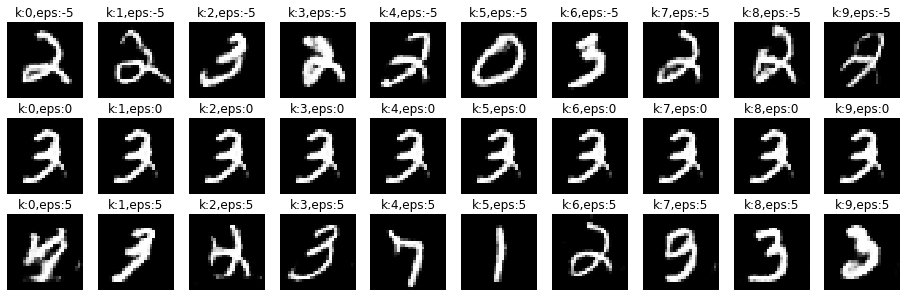

Epoch: 2000 / C Loss: 1.13285 / R Loss: 1.83683 / RCA: 0.746


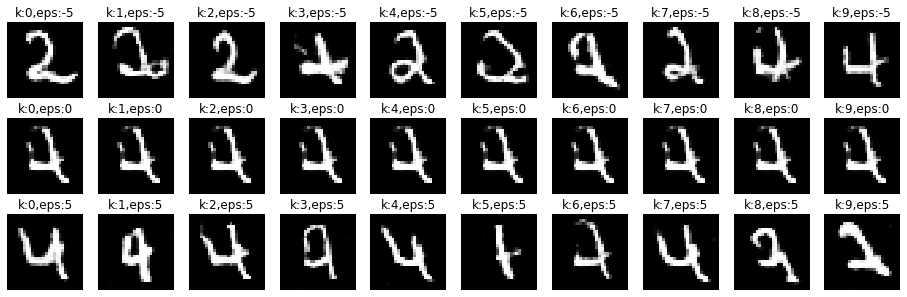

Epoch: 3000 / C Loss: 0.93626 / R Loss: 1.64802 / RCA: 0.822


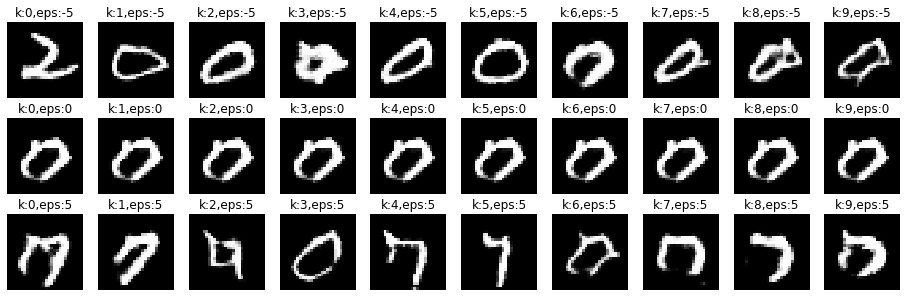

Epoch: 4000 / C Loss: 0.80461 / R Loss: 1.51712 / RCA: 0.864


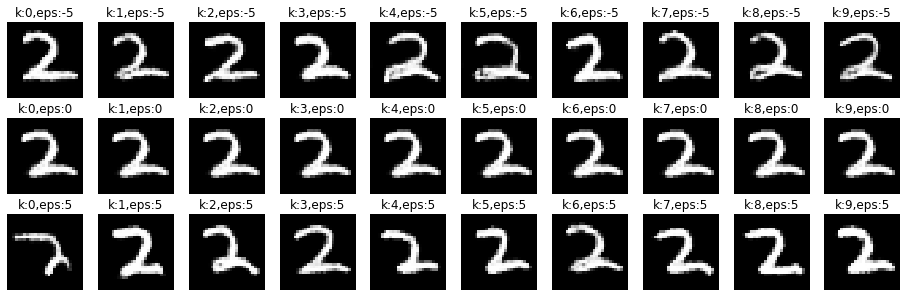

Epoch: 5000 / C Loss: 0.70997 / R Loss: 1.42056 / RCA: 0.889


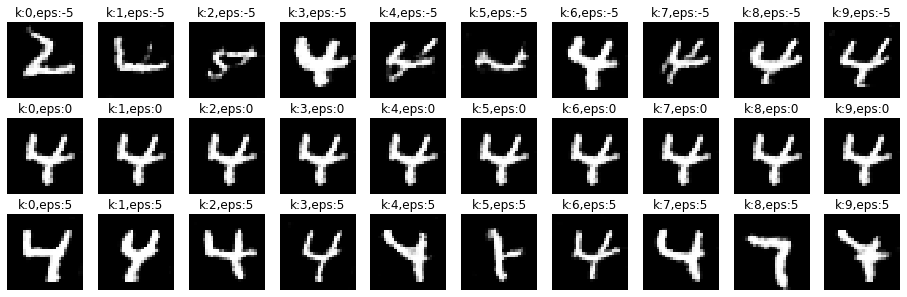

Epoch: 6000 / C Loss: 0.63919 / R Loss: 1.34518 / RCA: 0.905


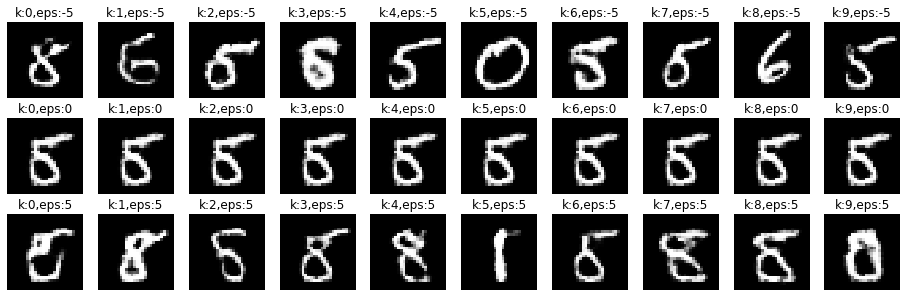

Epoch: 7000 / C Loss: 0.58370 / R Loss: 1.28577 / RCA: 0.916


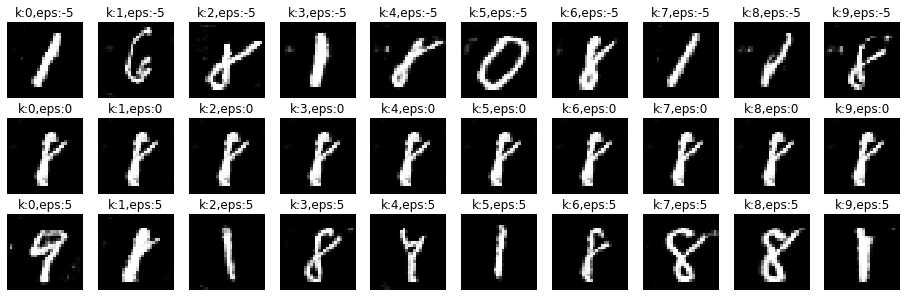

Epoch: 8000 / C Loss: 0.53856 / R Loss: 1.23681 / RCA: 0.925


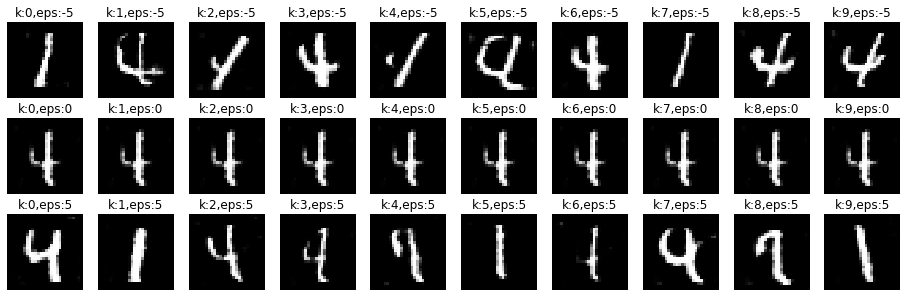

Epoch: 9000 / C Loss: 0.50151 / R Loss: 1.19527 / RCA: 0.931


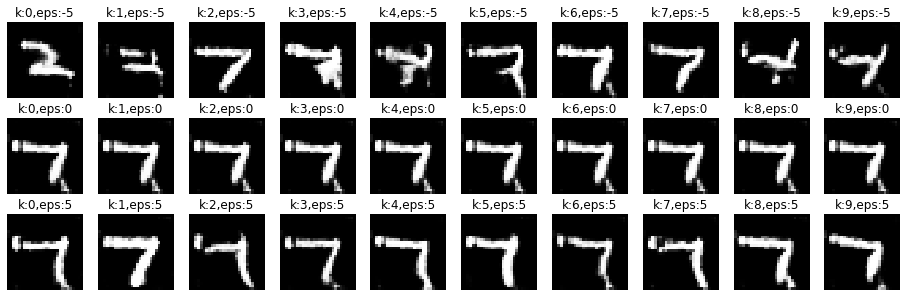

Epoch: 10000 / C Loss: 0.47001 / R Loss: 1.15954 / RCA: 0.936


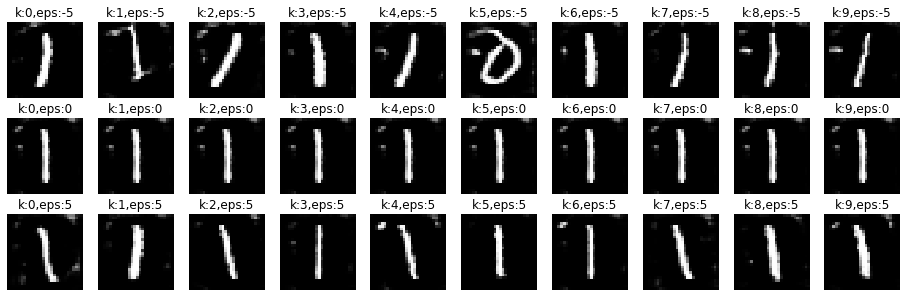

Epoch: 11000 / C Loss: 0.44327 / R Loss: 1.12856 / RCA: 0.940


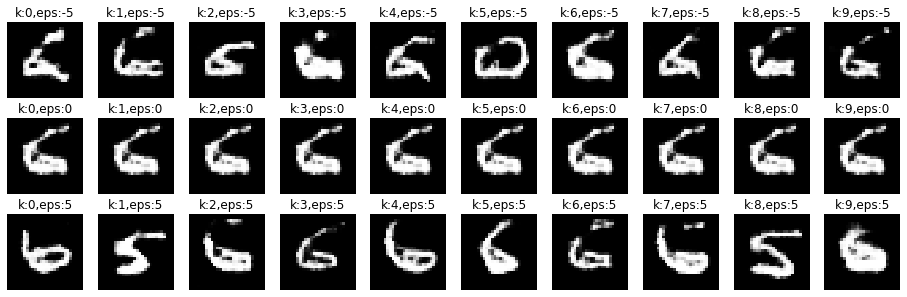

Epoch: 12000 / C Loss: 0.41996 / R Loss: 1.10123 / RCA: 0.944


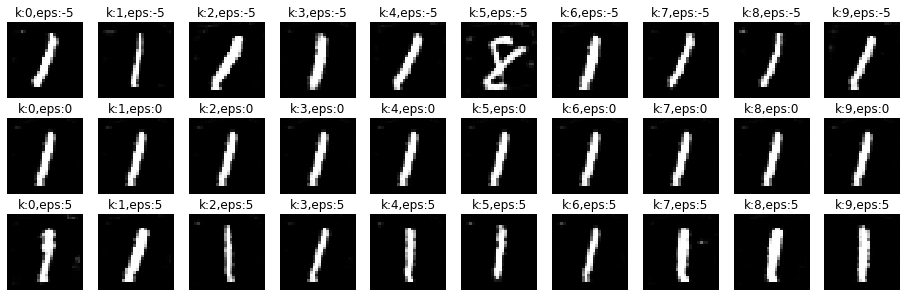

Epoch: 13000 / C Loss: 0.39939 / R Loss: 1.07675 / RCA: 0.948


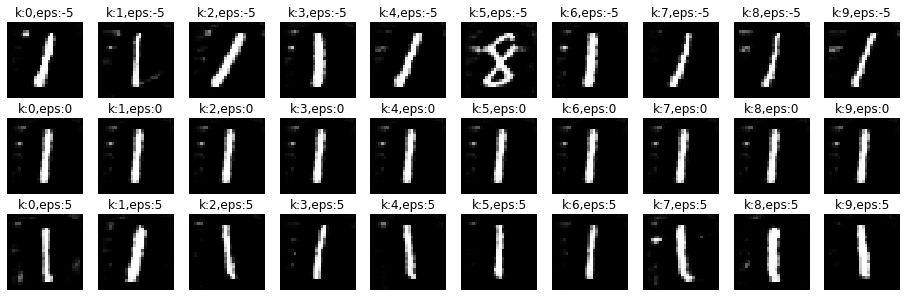

Epoch: 14000 / C Loss: 0.38135 / R Loss: 1.05451 / RCA: 0.950


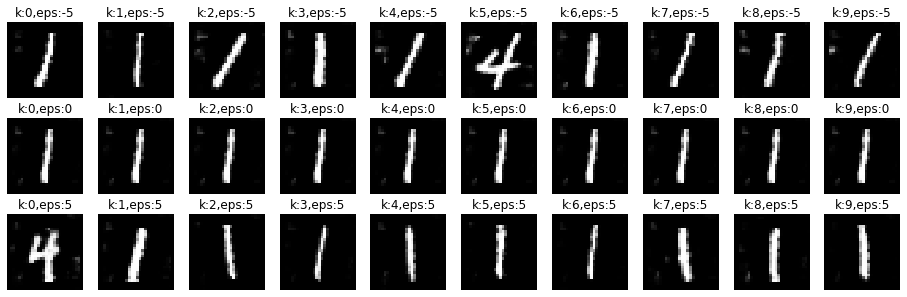

Epoch: 15000 / C Loss: 0.36496 / R Loss: 1.03446 / RCA: 0.954


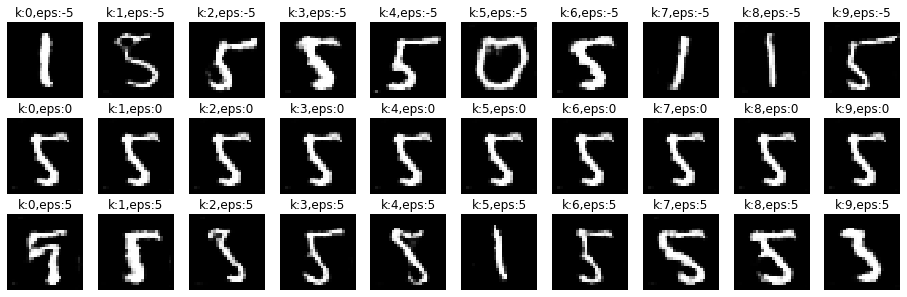

Epoch: 16000 / C Loss: 0.35023 / R Loss: 1.01616 / RCA: 0.956


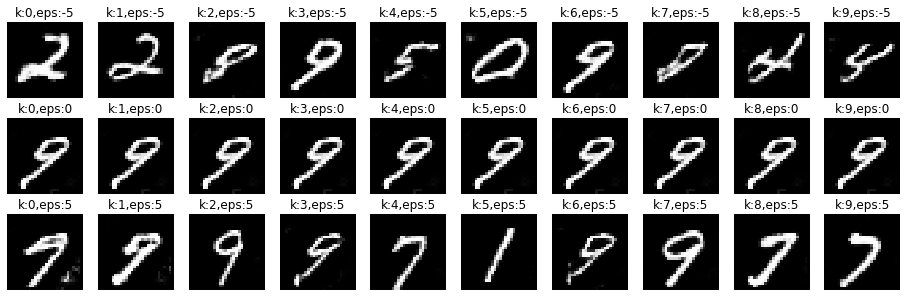

Epoch: 17000 / C Loss: 0.33695 / R Loss: 0.99904 / RCA: 0.957


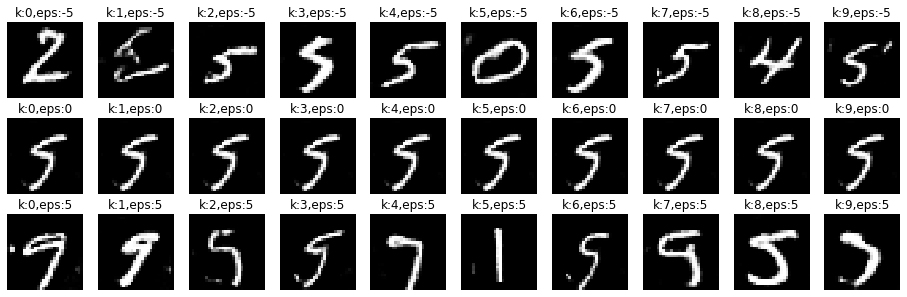

Epoch: 18000 / C Loss: 0.32492 / R Loss: 0.98331 / RCA: 0.960


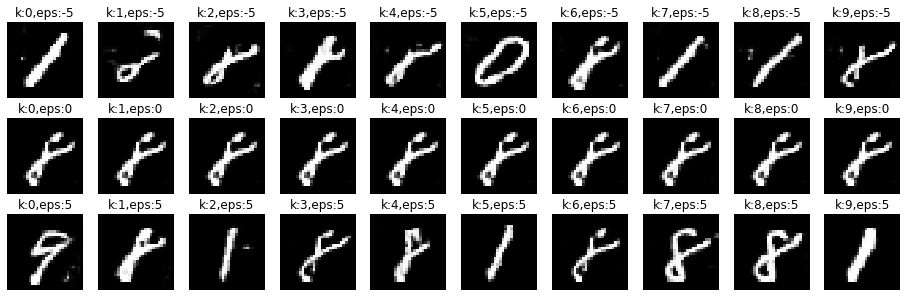

Epoch: 19000 / C Loss: 0.31392 / R Loss: 0.96887 / RCA: 0.960


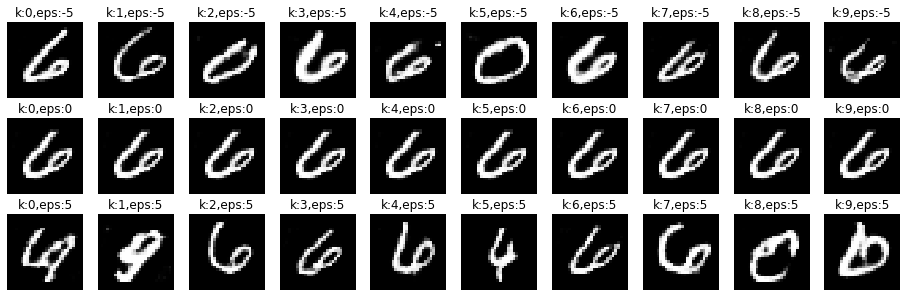

Epoch: 20000 / C Loss: 0.30381 / R Loss: 0.95527 / RCA: 0.962


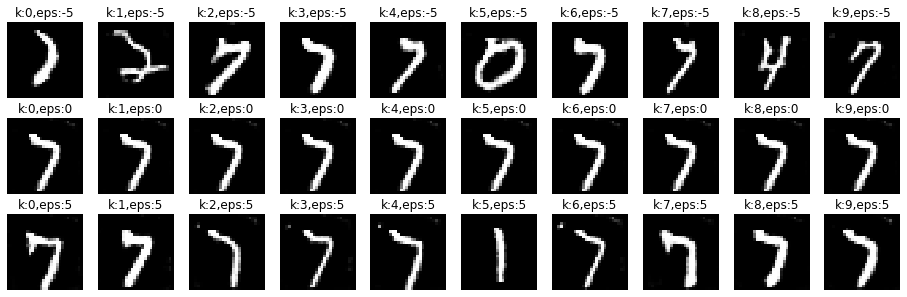

Epoch: 21000 / C Loss: 0.29439 / R Loss: 0.94238 / RCA: 0.964


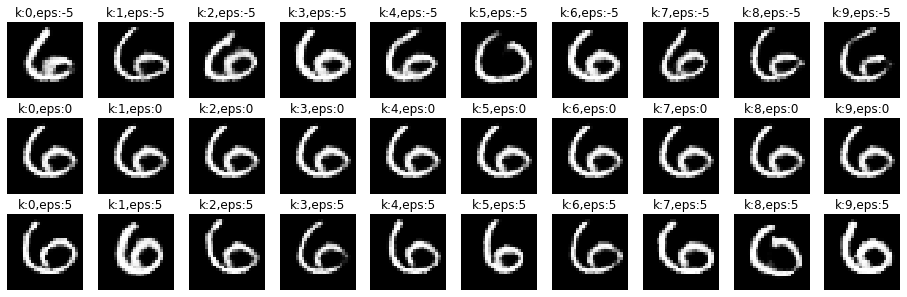

Epoch: 22000 / C Loss: 0.28567 / R Loss: 0.93025 / RCA: 0.965


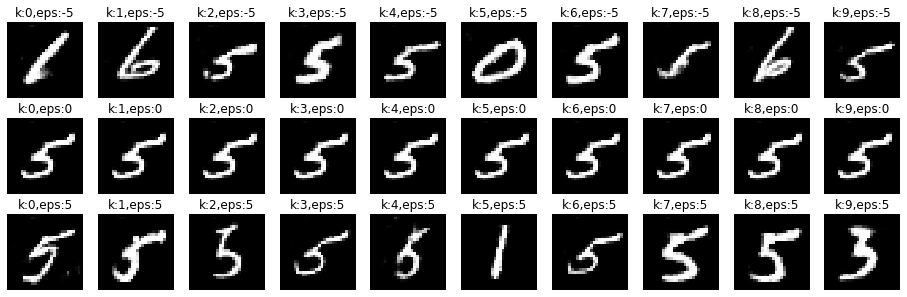

Epoch: 23000 / C Loss: 0.27766 / R Loss: 0.91883 / RCA: 0.965


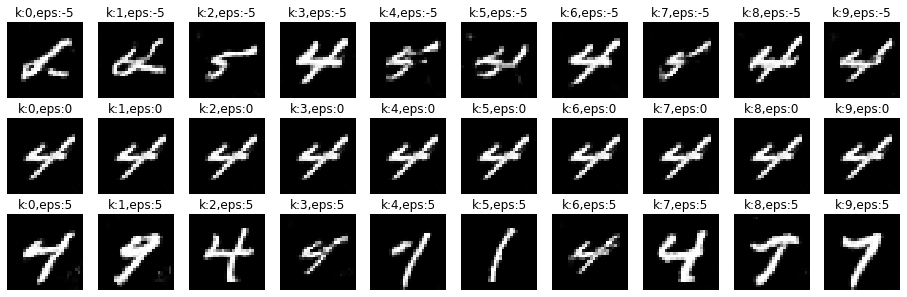

Epoch: 24000 / C Loss: 0.27018 / R Loss: 0.90809 / RCA: 0.966


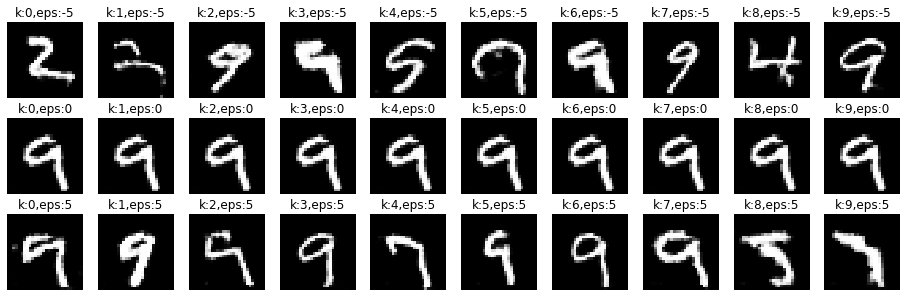

Epoch: 25000 / C Loss: 0.26314 / R Loss: 0.89791 / RCA: 0.968


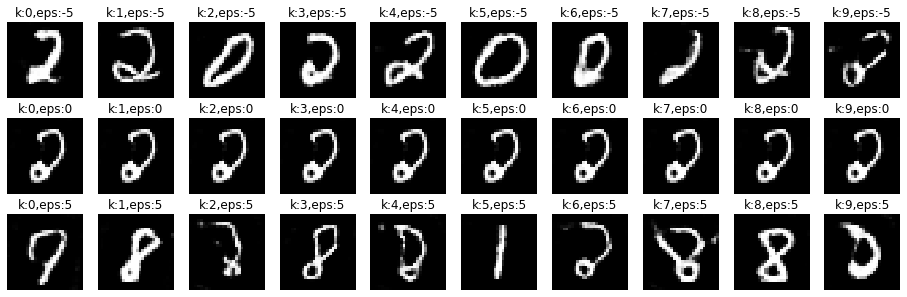

Epoch: 26000 / C Loss: 0.25652 / R Loss: 0.88821 / RCA: 0.969


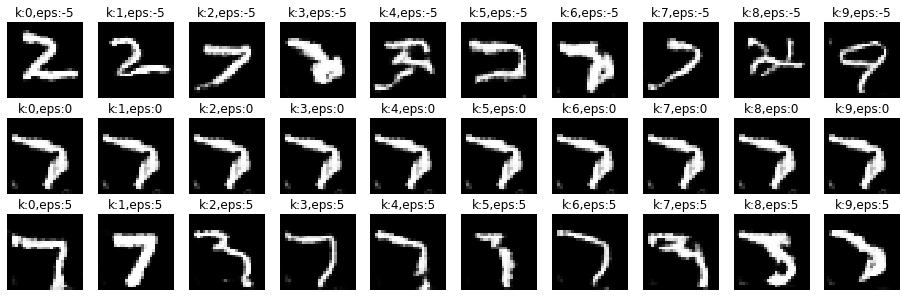

Epoch: 27000 / C Loss: 0.25042 / R Loss: 0.87911 / RCA: 0.969


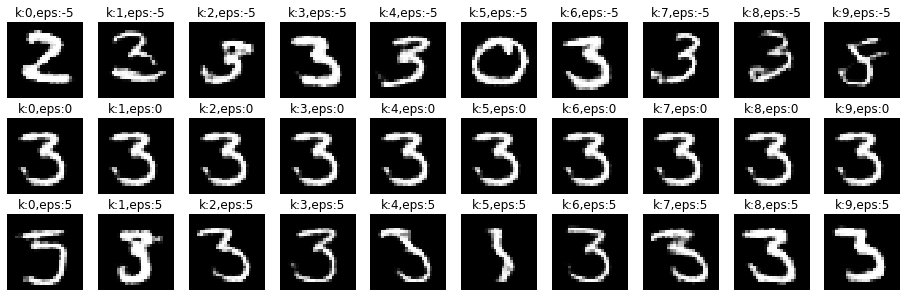

Epoch: 28000 / C Loss: 0.24461 / R Loss: 0.87022 / RCA: 0.970


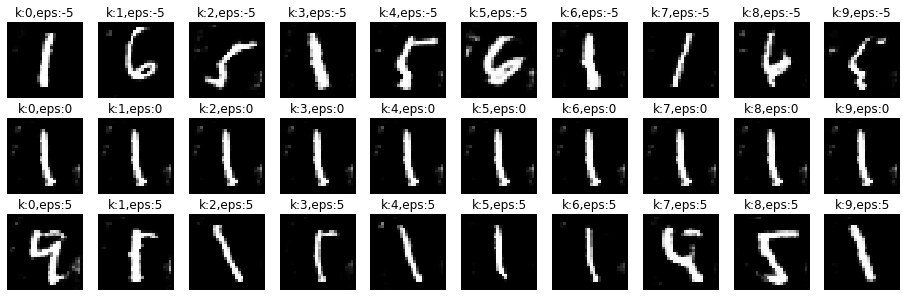

Epoch: 29000 / C Loss: 0.23913 / R Loss: 0.86166 / RCA: 0.971


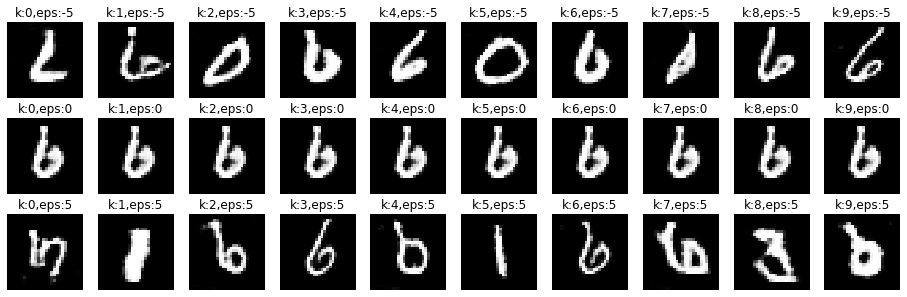

Epoch: 30000 / C Loss: 0.23388 / R Loss: 0.85352 / RCA: 0.972


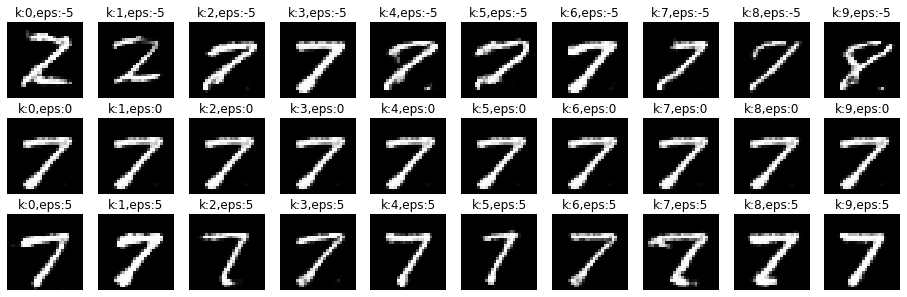

Epoch: 31000 / C Loss: 0.22897 / R Loss: 0.84572 / RCA: 0.972


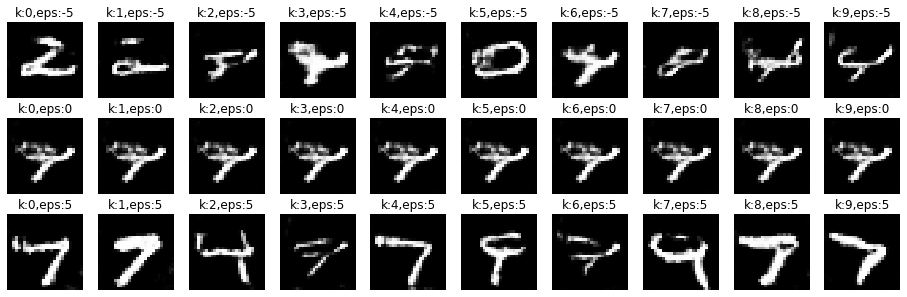

Epoch: 32000 / C Loss: 0.22431 / R Loss: 0.83825 / RCA: 0.973


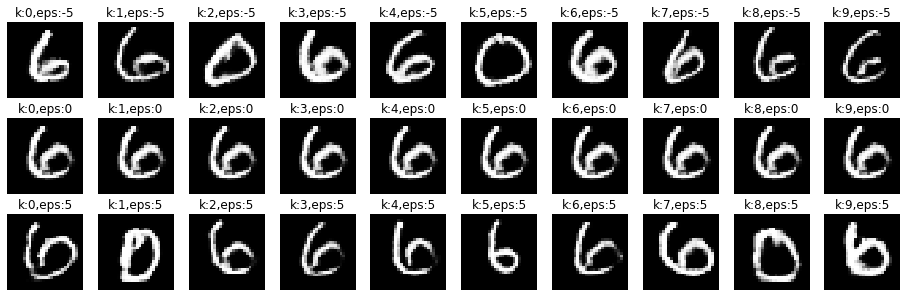

Epoch: 33000 / C Loss: 0.21987 / R Loss: 0.83109 / RCA: 0.973


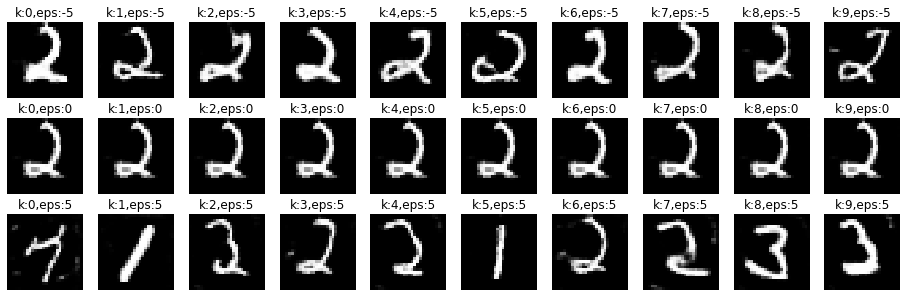

Epoch: 34000 / C Loss: 0.21565 / R Loss: 0.82407 / RCA: 0.974


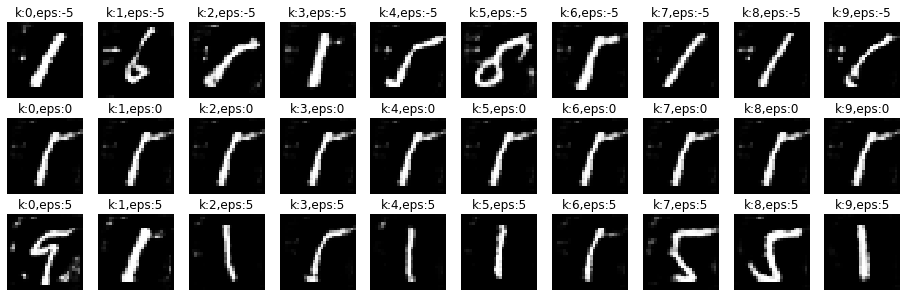

Epoch: 35000 / C Loss: 0.21158 / R Loss: 0.81738 / RCA: 0.975


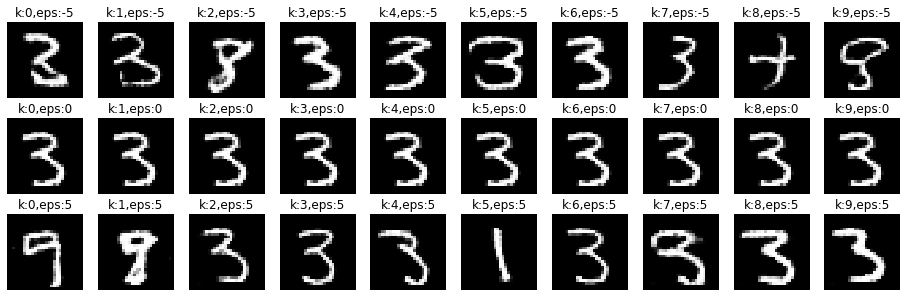

Epoch: 36000 / C Loss: 0.20771 / R Loss: 0.81085 / RCA: 0.975


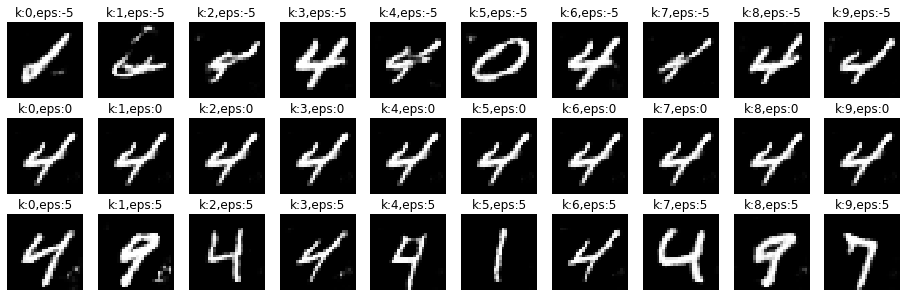

Epoch: 37000 / C Loss: 0.20402 / R Loss: 0.80455 / RCA: 0.976


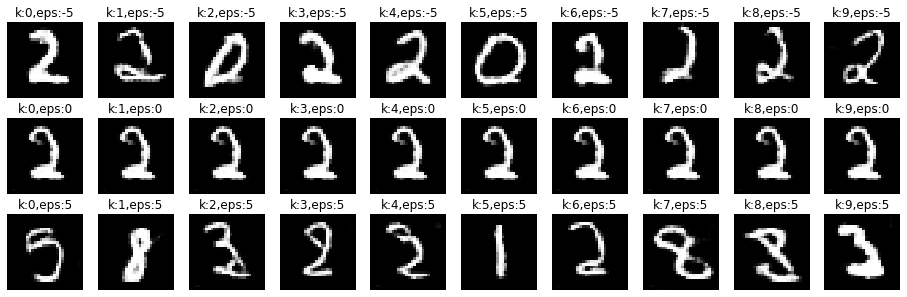

Epoch: 38000 / C Loss: 0.20051 / R Loss: 0.79854 / RCA: 0.976


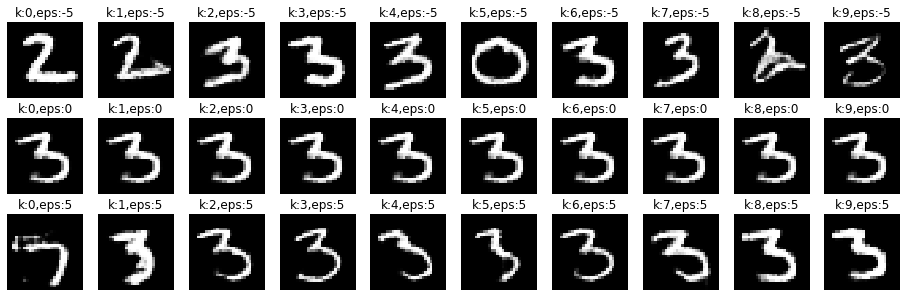

Epoch: 39000 / C Loss: 0.19714 / R Loss: 0.79261 / RCA: 0.976


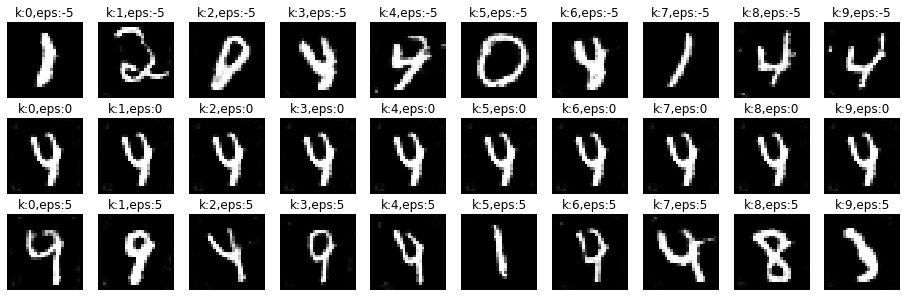

Epoch: 40000 / C Loss: 0.19396 / R Loss: 0.78687 / RCA: 0.976


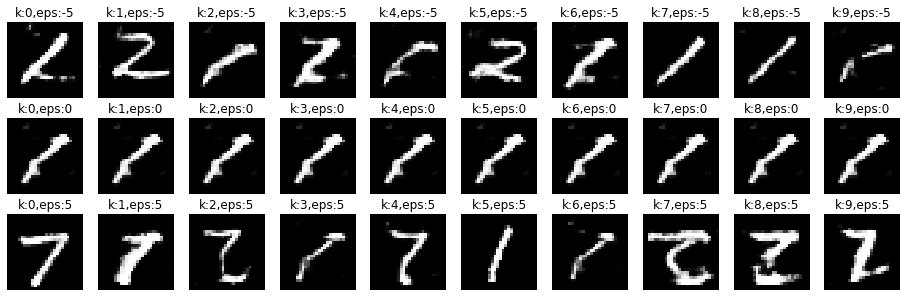

Epoch: 41000 / C Loss: 0.19085 / R Loss: 0.78135 / RCA: 0.977


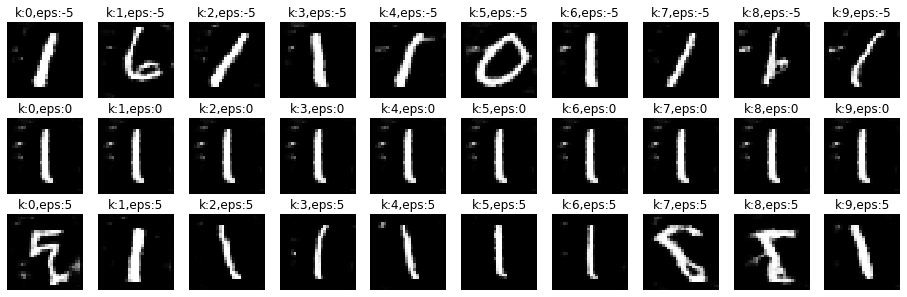

Epoch: 42000 / C Loss: 0.18785 / R Loss: 0.77596 / RCA: 0.978


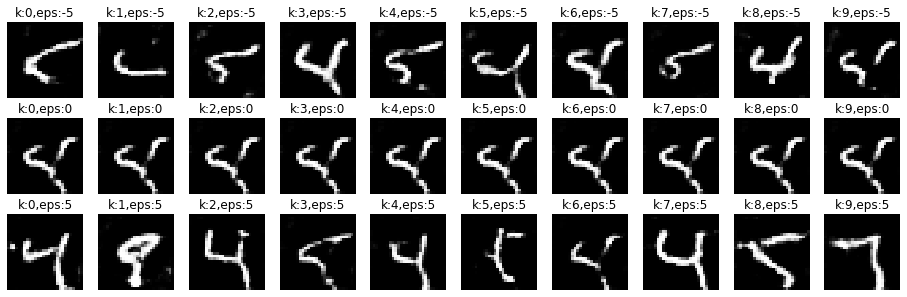

Epoch: 43000 / C Loss: 0.18501 / R Loss: 0.77078 / RCA: 0.978


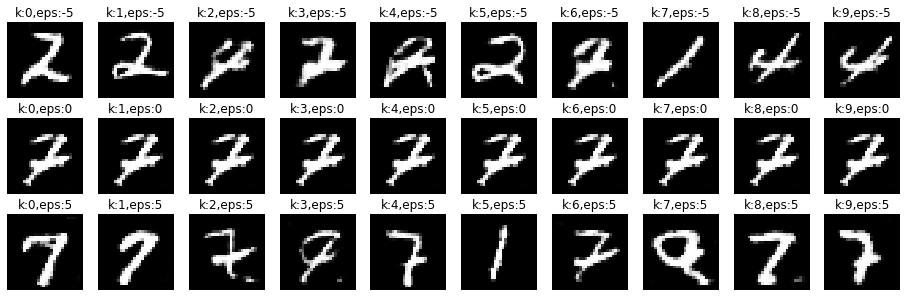

Epoch: 44000 / C Loss: 0.18226 / R Loss: 0.76568 / RCA: 0.978


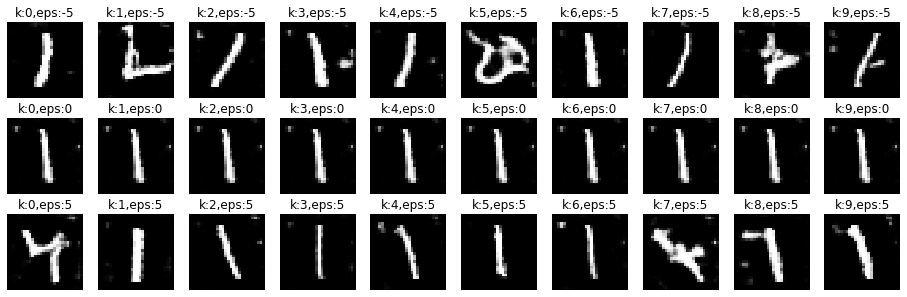

Epoch: 45000 / C Loss: 0.17961 / R Loss: 0.76068 / RCA: 0.979


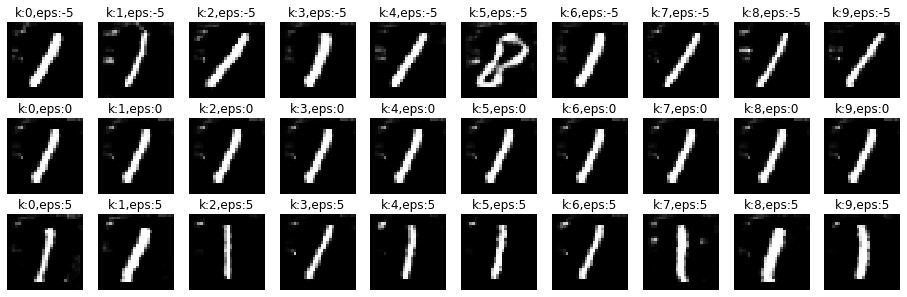

Epoch: 46000 / C Loss: 0.17700 / R Loss: 0.75586 / RCA: 0.980


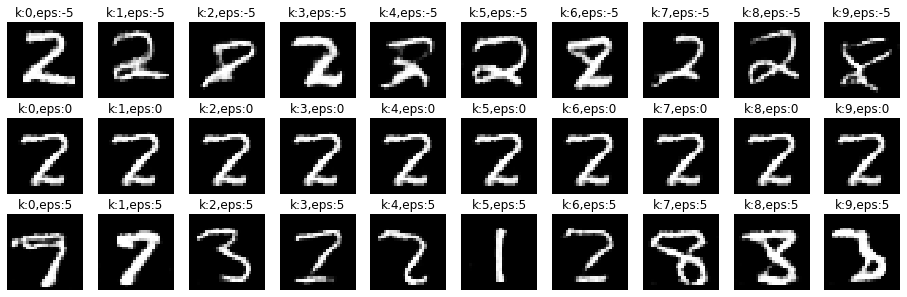

Epoch: 47000 / C Loss: 0.17456 / R Loss: 0.75123 / RCA: 0.979


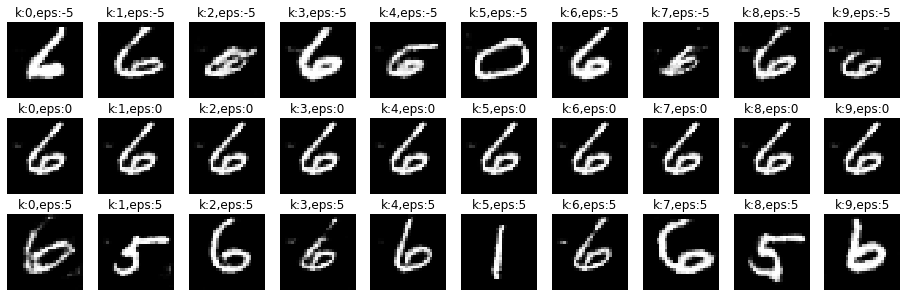

Epoch: 48000 / C Loss: 0.17219 / R Loss: 0.74661 / RCA: 0.980


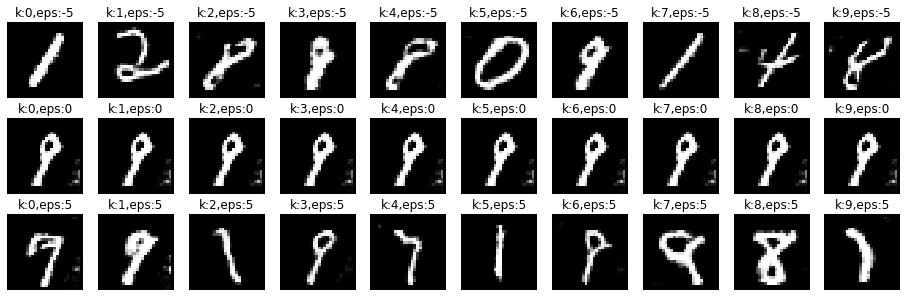

Epoch: 49000 / C Loss: 0.16988 / R Loss: 0.74208 / RCA: 0.981


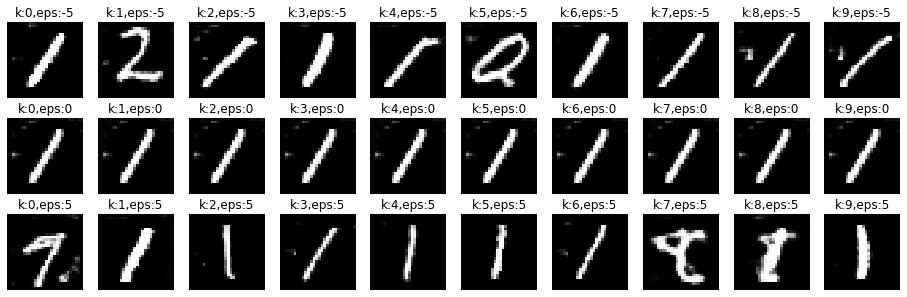

In [10]:
if train_model:
    
    c_loss_list = []
    r_loss_list = []
    RCA_list = []
    
    c_loss_plot = []
    r_loss_plot = []
    RCA_plot = []
    
    for i in range(num_iter):
        # Sample Z
        sampled_z = np.random.uniform(-1, 1, size=(batch_size, n_latent))
        
        # Sample K
        sampled_k = np.zeros([batch_size, n_dir])
        idx_k = np.random.choice(n_dir, batch_size)        
        
        # Sample eps
        sampled_eps = np.random.uniform(-6, 6, size=(batch_size, 1))
        
        for j in range(batch_size):
            sampled_k[j,idx_k[j]] = 1
            
            eps_ = sampled_eps[j,0]
            sampled_eps[j,0] = np.sign(eps_)*np.max([np.abs(eps_), 0.5])

        _, c_loss_train, r_loss_train, k_train = sess.run([train_step, c_loss, r_loss, out_k], feed_dict = {
                                                                                                z: sampled_z, 
                                                                                                k: sampled_k, 
                                                                                                eps: sampled_eps, 
                                                                                                is_training: True})
        c_loss_list.append(c_loss_train)
        r_loss_list.append(r_loss_train)
        
        sample_k_idx = np.argmax(sampled_k, axis=1)
        out_k_idx = np.argmax(k_train, axis=1)    
            
        count_acc = 0
        for j in range(batch_size):
            if sample_k_idx[j]==out_k_idx[j]:
                count_acc+=1
                
        RCA_list.append(count_acc/batch_size)
        
        print("Iter: {} / {}".format(i, num_iter), end="\r")

        # Print Progess
        if i % show_result_iter == 0 and i != 0:
            print("Epoch: {} / C Loss: {:.5f} / R Loss: {:.5f} / RCA: {:.3f}".format(
                  (i), np.mean(c_loss_list), np.mean(r_loss_list), np.mean(RCA_list)))
            
            c_loss_plot.append(np.mean(c_loss_list))
            r_loss_plot.append(np.mean(r_loss_list))
            RCA_plot.append(np.mean(RCA_list))
            
            train_c_loss_list = []
            train_r_loss_list = []
            RCA_list = []

            # Show test images 
            z_test = np.zeros([n_dir, n_latent])
            z_temp = np.random.uniform(-1, 1, size=(1, n_latent))
                        
            k_test = np.zeros([n_dir, n_dir])
            
            for j in range(n_dir):
                z_test[j,:] = z_temp
                k_test[j,j] = 1
              
            # Sample eps
            eps_test1 = -5*np.ones([n_dir, 1])
            eps_test2 = 5*np.ones([n_dir, 1])

            G_out, shift_G_out1 = sess.run([G, shifted_G], feed_dict = {z: z_test, k: k_test,eps: eps_test1,
                                                                        is_training: True})

            G_out, shift_G_out2 = sess.run([G, shifted_G], feed_dict = {z: z_test, k: k_test,eps: eps_test2,
                                                                        is_training: True})
                
            f, ax = plt.subplots(3,n_dir,figsize=(16,5))
            for m in range(3):
                for n in range(n_dir):
                    if m == 0:
                        ax[m,n].imshow(shift_G_out1[n,:,:,0], cmap = 'gray')
                        ax[m,n].axis('off')
                        ax[m,n].set_title('k:'+str(n) + ',eps:-5')
                    if m == 1:
                        ax[m,n].imshow(G_out[n,:,:,0], cmap = 'gray')
                        ax[m,n].axis('off')
                        ax[m,n].set_title('k:'+str(n) + ',eps:0')                    
                    if m == 2:
                        ax[m,n].imshow(shift_G_out2[n,:,:,0], cmap = 'gray')
                        ax[m,n].axis('off')
                        ax[m,n].set_title('k:'+str(n) + ',eps:5')       
                        
            plt.show()

## Image Generation

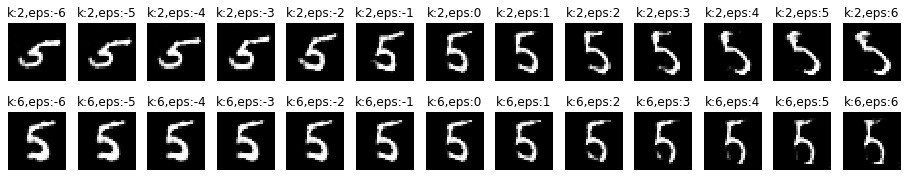

In [61]:
# Type k for testing
k_list = [2, 6]

z_result = np.random.uniform(-1, 1, size=(1, n_latent))

f, ax = plt.subplots(len(k_list),13,figsize=(16,3))

for i, k_idx in enumerate(k_list):
   
    k_result = np.zeros([1, n_dir])
    k_result[0,k_idx] = 1
        
    for j, eps_ in enumerate(range(-6,7)):
        eps_result = np.array([eps_])
        shift_G_out = sess.run(shifted_G, feed_dict = {z: z_result, k: k_result,
                                                            eps: [eps_result], is_training: True})
        ax[i,j].imshow(shift_G_out[0,:,:,0], cmap = 'gray')
        ax[i,j].axis('off')
        ax[i,j].set_title('k:'+str(k_idx) + ',eps:'+str(eps_))
   
plt.show()

## Save Model

In [12]:
os.mkdir(save_path)

Saver.save(sess, save_path + "/model/model")
print("Model is saved in {}".format(save_path + "/model/model"))

Model is saved in ./saved_models/20200306-15-32-08_Unsupervised_Latent_MNIST/model/model
